In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

In [2]:
original_data = pd.read_csv('../dataset/mohler2_cleaned.csv')
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'question_number':'question_id','question_text':'question','answer_model':'ref_answer','answer_student':'student_answer','score_avg':'grade'})

In [3]:
df = original_data.copy()

#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

df

,question_id,question,ref_answer,student_answer,grade,ref_modified,student_modified
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,simulate behaviour portion desired software pr...,high risk problem address prototype program ma...
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,simulate behaviour portion desired software pr...,simulate portion desired final product quick e...
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,simulate behaviour portion desired software pr...,prototype program simulates behavior portion d...
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,simulate behaviour portion desired software pr...,defined specification phase prototype stimulat...
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,simulate behaviour portion desired software pr...,used let user first idea completed program all...
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,simulate behaviour portion desired software pr...,find problem error program finalized
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,simulate behaviour portion desired software pr...,address major issue creation program way accou...
7,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,you can break the whole program into prototype...,5.0,simulate behaviour portion desired software pr...,break whole program prototype program simulate...
8,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To provide an example or model of how the fini...,3.5,simulate behaviour portion desired software pr...,provide example model finished program perfom ...
9,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Simulating the behavior of only a portion of t...,5.0,simulate behaviour portion desired software pr...,simulating behavior portion desired software p...


In [4]:
short_df = df[['student_answer','student_modified', 'grade','question']]
# np.sort(short_df['grade'].unique())
short_df['grades_round']= short_df['grade'].apply(lambda x: round(x))
# short_df['status'] = short_df['grade'] >= 3
# short_df['status'] = short_df['status'].astype(int)

/home/black-book/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
#getting the seed index
classes = short_df['grades_round'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['grades_round'][short_df['grades_round']==i].index[0])
seed_index

[0, 1, 4, 5, 52, 94]

In [6]:
# short_df['word_count'] = short_df['student_answer'].apply(lambda x: dict(Counter(x.split())))

# counting unique words in every student's answer
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = short_df['grades_round'].values

In [7]:
act_data = short_df.copy()
accuracy_list = []

# initialising
# train_idx = [0, 1, 4 ,5,52,605]
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
print(y_train)
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
lr = LogisticRegression()
learner = ActiveLearner(
    estimator = lr,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = 40
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
    print("\nQ: ", act_data.loc[int(query_idx),'question'])
    print("A: ",act_data.loc[int(query_idx),'student_answer'])
    print("Actual grade: ",y_pool[query_idx].reshape(1, ))
    print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
    human_label = int(input("\nGive me a grade:"))
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=[human_label]
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X,Y))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X, Y)))

[4 5 3 2 1 0]

Q:  How do you delete a node from a binary search tree?
A:  In a binary search tree  you must first establish a proper replacement for the node you are about to delete  usually a child from the soon to be deleted node.  Once that replacement node has been found  you simply reassign it to where the node that is going to be deleted is.  After the deleted node has been usurped  you remove the deleted node from memory so it may be used again. 
Actual grade:  [4]
Class probabilities:  [[0.18297421 0.14870677 0.1507371  0.17713173 0.17996202 0.16048817]]

Give me a grade:4
Accuracy after query no. 1: 0.079853

Q:  What is the main advantage of arrays over linked lists?
A:  arrays allow for the random access of any item cotained a any time  linked lists must be gone through toget to the desired item 
Actual grade:  [5]
Class probabilities:  [[0.18166849 0.17631216 0.15952705 0.16272081 0.15251353 0.16725796]]

Give me a grade:5
Accuracy after query no. 2: 0.194513

Q:  What is 


Give me a grade:4
Accuracy after query no. 23: 0.489353

Q:  What are the main operations associated with a stack?
A:  push  pop  search  isEmpty 
Actual grade:  [4]
Class probabilities:  [[0.1220864  0.1066266  0.19993798 0.10153827 0.22966416 0.2401466 ]]

Give me a grade:4
Accuracy after query no. 24: 0.427109

Q:  Order the following functions by their running time: n^2  log(log n)   2^(log n)   n!   n^3.
A:  this goes from largest to smallest: n!  n to the power of 3  n to the power of 2  2 to the power of -LRB- log n -RRB-   log -LRB- log n -RRB- 
Actual grade:  [5]
Class probabilities:  [[0.11581845 0.10212031 0.20828127 0.0979372  0.23891768 0.23692509]]

Give me a grade:5
Accuracy after query no. 25: 0.437346

Q:  What stages in the software life cycle are influenced by the testing stage?
A:  Depending on how the work is done  Testing is spread throughout the process as to prevent errors from showing up later on due to lack of foresight. 
Actual grade:  [2]
Class probabilitie

## Regular supervised task

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)

In [10]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y_train)
score = logisticRegr.score(X_test, Y_test)

print(score)

0.5971370143149284


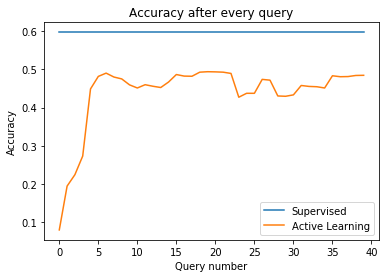

In [11]:
supervised_accuracy = [score for x in range(0,40)]

plt.figure()
plt.plot(np.linspace(0,39,40),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()